# 데이터 준비


In [2]:
import pandas as pd
from pandas import DataFrame

import numpy as np
import pymysql
# from sklearn.preprocessing import MinMaxScaler
# from feature_engine.encoding import OneHotEncoder
# from imblearn.over_sampling import SMOTE

from xgboost import plot_importance, plot_tree
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns
import gc
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold



import lightgbm as lgb


import keras
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector


2022-05-19 21:00:17.658244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 21:00:17.658312: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [26]:
b_QUERY = """
        SELECT * 
        FROM bike 
        WHERE (date BETWEEN DATE_ADD(NOW(), INTERVAL -2 DAY ) AND NOW())
        AND minute(date) in (0, 30);
        """

In [ ]:
b_QUERY = """
        SELECT * 
        FROM bike 
        WHERE (date BETWEEN DATE_SUB(NOW(), INTERVAL 2 DAY ) AND NOW())
        AND minute(date) in (round(minute(NOW()), -1),round(minute(DATE_ADD(NOW(), INTERVAL 30 MINUTE)), -1));
        """

In [4]:
# 서버시간 맞추기 위해서
q = "select @@global.time_zone, @@session.time_zone,@@system_time_zone;"
q1 = "SET GLOBAL time_zone='+09:00';"
q2 = "SET time_zone='+09:00';"
q3 = "select now()"

In [27]:
conn = pymysql.connect(
    host='172.18.0.2', 
    port=3306,
    user='root',
    passwd='insight2022',
    db='insight',
    charset='utf8',
    autocommit=False
)

cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)


cursor.execute(b_QUERY)
bike_data = cursor.fetchall() # list of dictionary
bike_df = pd.DataFrame.from_dict(bike_data)

cursor.close()
conn.close()


In [28]:
bike_df.tail()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
247771,7395566,16,1,6,ST-3031,2022-05-19 21:00:04
247772,7395567,4,4,100,ST-3015,2022-05-19 21:00:04
247773,7395568,15,7,47,ST-3040,2022-05-19 21:00:04
247774,7395569,7,3,43,ST-3041,2022-05-19 21:00:04
247775,7395570,2,0,0,ST-1747,2022-05-19 21:00:04


In [29]:
bike_df[2400:2700]

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
2400,5924220,8,0,0,ST-2648,2022-05-17 21:30:02
2401,5924221,6,0,0,ST-2694,2022-05-17 21:30:02
2402,5924222,10,7,70,ST-2852,2022-05-17 21:30:02
2403,5924223,18,0,0,ST-2899,2022-05-17 21:30:02
2404,5924224,20,0,0,ST-2900,2022-05-17 21:30:02
...,...,...,...,...,...,...
2695,5937420,10,1,10,ST-285,2022-05-17 22:00:02
2696,5937421,20,47,235,ST-286,2022-05-17 22:00:02
2697,5937422,10,12,120,ST-287,2022-05-17 22:00:02
2698,5937423,20,28,140,ST-288,2022-05-17 22:00:02


In [30]:
type(bike_df['date'])

pandas.core.series.Series

In [31]:
len(bike_df['date'])

247776

In [32]:
bike_df['date']=bike_df['date'].dt.strftime('%Y-%m-%d %H시%M분')
bike_df.head()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
0,5921820,15,10,67,ST-4,2022-05-17 21시30분
1,5921821,14,8,57,ST-5,2022-05-17 21시30분
2,5921822,13,1,8,ST-6,2022-05-17 21시30분
3,5921823,5,0,0,ST-7,2022-05-17 21시30분
4,5921824,12,0,0,ST-8,2022-05-17 21시30분


In [33]:
bike_df = bike_df.drop_duplicates(['station_id', 'date'])

In [34]:
data = bike_df.pivot(index='station_id', columns='date', values='parking_bike_tot_cnt')
data

date,2022-05-17 21시30분,2022-05-17 22시00분,2022-05-17 22시30분,2022-05-17 23시00분,2022-05-17 23시30분,2022-05-18 00시00분,2022-05-18 00시30분,2022-05-18 01시00분,2022-05-18 01시30분,2022-05-18 02시00분,...,2022-05-19 16시30분,2022-05-19 17시00분,2022-05-19 17시30분,2022-05-19 18시00분,2022-05-19 18시30분,2022-05-19 19시00분,2022-05-19 19시30분,2022-05-19 20시00분,2022-05-19 20시30분,2022-05-19 21시00분
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,1,1,0,2,3,0,0,1,0,0,...,25,21,22,16,12,12,10,6,4,3
ST-1000,39,43,45,50,56,60,62,64,66,67,...,16,18,20,22,24,24,31,35,29,32
ST-1002,7,2,1,0,0,0,1,1,2,1,...,22,25,26,28,19,13,9,6,6,0
ST-1003,14,14,19,19,18,21,25,23,24,24,...,7,8,5,5,5,6,9,12,15,14
ST-1004,16,19,19,20,19,19,19,20,19,19,...,21,25,23,19,19,18,19,19,19,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST-993,18,20,25,27,28,27,27,28,28,29,...,8,8,11,14,16,21,27,29,30,33
ST-994,7,3,0,1,1,1,2,2,2,1,...,45,50,50,44,30,22,17,19,12,12
ST-995,5,5,2,2,2,2,2,2,2,2,...,4,3,2,2,3,5,6,7,4,4


In [35]:
# 중복 데이터 record 확인
data[data.duplicated(keep = False)]

date,2022-05-17 21시30분,2022-05-17 22시00분,2022-05-17 22시30분,2022-05-17 23시00분,2022-05-17 23시30분,2022-05-18 00시00분,2022-05-18 00시30분,2022-05-18 01시00분,2022-05-18 01시30분,2022-05-18 02시00분,...,2022-05-19 16시30분,2022-05-19 17시00분,2022-05-19 17시30분,2022-05-19 18시00분,2022-05-19 18시30분,2022-05-19 19시00분,2022-05-19 19시30분,2022-05-19 20시00분,2022-05-19 20시30분,2022-05-19 21시00분
station_id,,,,,,,,,,,,,,,,,,,,,


## X, Y 데이터 분리하기


In [36]:
data

date,2022-05-17 21시30분,2022-05-17 22시00분,2022-05-17 22시30분,2022-05-17 23시00분,2022-05-17 23시30분,2022-05-18 00시00분,2022-05-18 00시30분,2022-05-18 01시00분,2022-05-18 01시30분,2022-05-18 02시00분,...,2022-05-19 16시30분,2022-05-19 17시00분,2022-05-19 17시30분,2022-05-19 18시00분,2022-05-19 18시30분,2022-05-19 19시00분,2022-05-19 19시30분,2022-05-19 20시00분,2022-05-19 20시30분,2022-05-19 21시00분
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,1,1,0,2,3,0,0,1,0,0,...,25,21,22,16,12,12,10,6,4,3
ST-1000,39,43,45,50,56,60,62,64,66,67,...,16,18,20,22,24,24,31,35,29,32
ST-1002,7,2,1,0,0,0,1,1,2,1,...,22,25,26,28,19,13,9,6,6,0
ST-1003,14,14,19,19,18,21,25,23,24,24,...,7,8,5,5,5,6,9,12,15,14
ST-1004,16,19,19,20,19,19,19,20,19,19,...,21,25,23,19,19,18,19,19,19,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST-993,18,20,25,27,28,27,27,28,28,29,...,8,8,11,14,16,21,27,29,30,33
ST-994,7,3,0,1,1,1,2,2,2,1,...,45,50,50,44,30,22,17,19,12,12
ST-995,5,5,2,2,2,2,2,2,2,2,...,4,3,2,2,3,5,6,7,4,4


In [37]:
data.isnull().sum()

date
2022-05-17 21시30분    0
2022-05-17 22시00분    0
2022-05-17 22시30분    0
2022-05-17 23시00분    0
2022-05-17 23시30분    0
                    ..
2022-05-19 19시00분    0
2022-05-19 19시30분    0
2022-05-19 20시00분    0
2022-05-19 20시30분    0
2022-05-19 21시00분    0
Length: 96, dtype: int64

In [38]:
data = data.fillna(0)

In [39]:
X = data.drop(data.columns[-1], axis=1)
y = data[data.columns[-1]]

In [40]:
X

date,2022-05-17 21시30분,2022-05-17 22시00분,2022-05-17 22시30분,2022-05-17 23시00분,2022-05-17 23시30분,2022-05-18 00시00분,2022-05-18 00시30분,2022-05-18 01시00분,2022-05-18 01시30분,2022-05-18 02시00분,...,2022-05-19 16시00분,2022-05-19 16시30분,2022-05-19 17시00분,2022-05-19 17시30분,2022-05-19 18시00분,2022-05-19 18시30분,2022-05-19 19시00분,2022-05-19 19시30분,2022-05-19 20시00분,2022-05-19 20시30분
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,1,1,0,2,3,0,0,1,0,0,...,27,25,21,22,16,12,12,10,6,4
ST-1000,39,43,45,50,56,60,62,64,66,67,...,10,16,18,20,22,24,24,31,35,29
ST-1002,7,2,1,0,0,0,1,1,2,1,...,19,22,25,26,28,19,13,9,6,6
ST-1003,14,14,19,19,18,21,25,23,24,24,...,16,7,8,5,5,5,6,9,12,15
ST-1004,16,19,19,20,19,19,19,20,19,19,...,20,21,25,23,19,19,18,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST-993,18,20,25,27,28,27,27,28,28,29,...,10,8,8,11,14,16,21,27,29,30
ST-994,7,3,0,1,1,1,2,2,2,1,...,51,45,50,50,44,30,22,17,19,12
ST-995,5,5,2,2,2,2,2,2,2,2,...,5,4,3,2,2,3,5,6,7,4


In [41]:
y

station_id
ST-10       3
ST-1000    32
ST-1002     0
ST-1003    14
ST-1004    15
           ..
ST-993     33
ST-994     12
ST-995      4
ST-996      7
ST-997     43
Name: 2022-05-19 21시00분, Length: 2581, dtype: int64

In [42]:
# 라벨 값의 비율 확인 
y.value_counts()

0     510
1     265
2     204
3     171
5     119
     ... 
86      1
84      1
62      1
75      1
45      1
Name: 2022-05-19 21시00분, Length: 74, dtype: int64

## train / test 분리


In [43]:
y.isnull().sum()

0

In [44]:
# train, test 7:3 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [45]:
X_test.shape

(775, 95)

In [46]:
print("Train ratio of X:", X_train.shape[0] / X.shape[0])
print("Test ratio of X:", X_test.shape[0] / X.shape[0])

Train ratio of X: 0.6997287872917474
Test ratio of X: 0.30027121270825263


### DACON - XGboost



In [48]:
xgbr = xgb.XGBRegressor(verbosity=0) 
# print(xgbr)


xgbr.fit(X_train, y_train)


score = xgbr.score(X_train, y_train)  
print("\n Training score: ", score)

pred_score = xgbr.score(X_test, y_test)   
print("Testing score: ", pred_score) 
 

scores = cross_val_score(xgbr, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


y_pred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
mae = mean_absolute_error(y_test, y_pred)
print("mae: %.2f" % mae)



 Training score:  0.9999004735868349
Testing score:  0.9568026481187693
Mean cross-validation score: 0.95
K-fold CV average score: 0.95
MSE: 6.33
RMSE: 2.52
mae: 1.74


In [49]:
# 5분 뒤에 값을 예측한거임 -> 이후에 20분 뒤에를 예측 할 수 있도록 해보자 -> 어떻게 구별하지?
for i in range(100, 500, 20):
    print(str(y_pred[i]),'\t' ,str(y_test[i]), '\n')

0.95114905 	 1 

18.618147 	 18 

0.83037853 	 0 

6.6492844 	 8 

21.259682 	 19 

40.364677 	 40 

11.008868 	 8 

0.2588953 	 0 

26.6653 	 28 

3.3758996 	 1 

36.232212 	 36 

1.4527855 	 2 

11.400558 	 11 

-0.08240142 	 0 

25.353565 	 26 

7.2365522 	 12 

20.49831 	 18 

0.53792876 	 0 

2.9311945 	 5 

10.095986 	 11 



In [50]:

reg = xgb.XGBRegressor(max_depth = 4, n_estimators = 100)
reg.fit(X_train,y_train)


score = reg.score(X_train, y_train)   
print("Training score: ", score) 

pred_score = reg.score(X_test, y_test)   
print("Testing score: ", pred_score) 
 
# - cross validataion 
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())


#RMSE는 모델의 예측 값고 실제 값의 차이를 하나의 숫자로 표현


kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

# 숫자가 적을 수록 예측값과 실제 값의 차이가 적은 것을 의미함.
mae = mean_absolute_error(y_test, y_pred)
print("mae: %.2f" % mae)

Training score:  0.9969032891907978
Testing score:  0.9596188454567065
Mean cross-validation score: 0.94
K-fold CV average score: 0.95
MSE: 5.92
RMSE: 2.43
mae: 1.69


In [51]:
X_test.isna().sum()

date
2022-05-17 21시30분    0
2022-05-17 22시00분    0
2022-05-17 22시30분    0
2022-05-17 23시00분    0
2022-05-17 23시30분    0
                    ..
2022-05-19 18시30분    0
2022-05-19 19시00분    0
2022-05-19 19시30분    0
2022-05-19 20시00분    0
2022-05-19 20시30분    0
Length: 95, dtype: int64

In [52]:
# 5분 뒤에 값을 예측한거임 -> 이후에 20분 뒤에를 예측 할 수 있도록 해보자 -> 어떻게 구별하지?
for i in range(100, 500, 20):
    print(str(y_pred[i]),'\t' ,str(y_test[i]), '\n')

0.50192714 	 1 

19.11739 	 18 

0.71598774 	 0 

6.9742527 	 8 

19.532286 	 19 

40.353237 	 40 

10.640041 	 8 

0.14296637 	 0 

25.843555 	 28 

1.8541671 	 1 

33.911736 	 36 

1.3897187 	 2 

12.429255 	 11 

0.5006714 	 0 

26.472525 	 26 

8.3558445 	 12 

20.844313 	 18 

0.65056556 	 0 

2.063682 	 5 

10.315689 	 11 



In [53]:
# x_ax = range(len(y_test))
# plt.plot(x_ax, y_pred, label="predicted")
# plt.plot(x_ax, y_test, label="original")
# plt.legend()
# plt.show()

In [54]:
import matplotlib.pyplot as plt
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {'max_depth' : 4, 'n_estimators' : 100}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)



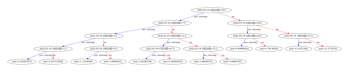

In [31]:
xgb.plot_tree(reg,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 200]
plt.show()

## LightGBM - 성능이 더 낮은 듯

In [47]:


# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

# prediction
y_pred = model.predict(X_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

# visualizing in a plot
# x_ax = range(len(y_test))
# plt.figure(figsize=(12, 6))
# plt.plot(x_ax, y_test, label="original")
# plt.plot(x_ax, y_pred, label="predicted")
# plt.title("Boston dataset test and predicted data")
# plt.xlabel('X')
# plt.ylabel('Price')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()  

# # plotting feature importance
# lgb.plot_importance(model, height=0.9) 

[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 120.342	valid_0's l1: 7.88985
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 98.8924	valid_0's l1: 7.16296
[3]	valid_0's l2: 81.6566	valid_0's l1: 6.51465
[4]	valid_0's l2: 67.673	valid_0's l1: 5.93362
[5]	valid_0's l2: 56.1932	valid_0's l1: 5.40909
[6]	valid_0's l2: 46.9398	valid_0's l1: 4.94206
[7]	valid_0's l2: 39.4675	valid_0's l1: 4.52853
[8]	valid_0's l2: 33.3874	valid_0's l1: 4.16371
[9]	valid_0's l2: 28.4696	valid_0's l1: 3.84301
[10]	valid_0's l2: 24.5254	valid_0's l1: 3.5567
[11]	valid_0's l2: 21.2383	valid_0's l1: 3.29614
[12]	valid_0's l2: 18.5154	valid_0's l1: 3.07091
[13]	valid_0's l2: 16.3427	valid_0's l1: 2.87373
[14]	valid_0's l2: 14.4859	valid_0's l1: 2.69773
[15]	valid_0's l2: 12.9844	valid_0's l1: 2.54425
[16]	valid_0's l2: 11.8077	valid_0's l1: 2.41504
[17]	valid_0's l2: 10.8206	valid_0's l1: 2.30345
[18]	valid_0's l2: 9.99891	valid_0's l1: 2.20412
[19]	valid_0's

/root/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0, flags=flags)


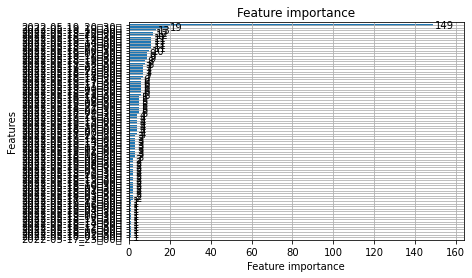

In [55]:
lgb.plot_importance(model, height=0.9) 

In [56]:
# 5분 뒤에 값을 예측한거임 -> 이후에 20분 뒤에를 예측 할 수 있도록 해보자 -> 어떻게 구별하지?
for i in range(100, 500, 20):
    print(str(y_pred[i]),'\t' ,str(y_test[i]), '\n')

0.50192714 	 1 

19.11739 	 18 

0.71598774 	 0 

6.9742527 	 8 

19.532286 	 19 

40.353237 	 40 

10.640041 	 8 

0.14296637 	 0 

25.843555 	 28 

1.8541671 	 1 

33.911736 	 36 

1.3897187 	 2 

12.429255 	 11 

0.5006714 	 0 

26.472525 	 26 

8.3558445 	 12 

20.844313 	 18 

0.65056556 	 0 

2.063682 	 5 

10.315689 	 11 

